## Part 3. Clustering: 
1 million samples problem (40 points). This part deals with the full dataset
of 1 million tweets. Your task is to design a system that can handle spatial clustering of 1M
samples.
Considering the memory limitations and scaling properties of the algorithms studied in Part 2,
design the clustering system that can be applied to the full dataset. Consider using a hierarchical
approach with two (or more) processing stages, where DBScan is applied to each cluster
obtained from a run of mini-batch k-means. By varying the parameters of the algorithms,
optimize the processing time required to detect clusters of tweets that correspond to important
locations in California. We will consider a location “important” if it is characterized with a
cluster’s core of at least 100 samples within a radius of 100 meters. Describe your approach to the design of the system in a write-up document and provide the total
number of clusters detected. Submit your code as a stand-alone script.

In [1]:
## import all necessary packages
import time
import json

import numpy as np
import matplotlib.pyplot as plt

from pandas import *

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
with open('tweets_1M.json','r') as f:
    tweets = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'tweets_1M.json'

In [ ]:
# #subset_tweets[:5]
# tweet_df = DataFrame(subset_tweets)
# tweet_df.head()

In [ ]:
# convert json into list of lat and long
coordinate_tweets = [value for item in tweets for key,value in item.items() if key in ['lat','lng']]

pair_coordinates = []
for i,k in zip(coordinate_tweets[0::2], coordinate_tweets[1::2]):
    pair_coordinates.append([i,k])

# convert pair to meters
pair_coordinates = [[item[0]*89.7, item[1]*112.7] for item in pair_coordinates]

print(len(pair_coordinates))
print(pair_coordinates[:5])

In [ ]:
fig_size = plt.rcParams["figure.figsize"]
 
# Prints: [8.0, 6.0]
print("Current size:", fig_size)
 
# Set figure width to 12 and height to 9
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

In [ ]:
# create scater plot
# outliers?
lat = [x[0] for x in pair_coordinates]
long = [x[1] for x in pair_coordinates]
# set axes range
plt.xlim(2800, 3800)
plt.ylim(-14500, -12500)
plt.scatter(lat, long, marker=u'.')


### Start with mini-batch clustering

In [ ]:
# create mini batch function that takes clustersize and batchsize as parameters
def mbk_time(cluster_size, batch_size):
    mbk = MiniBatchKMeans(init='k-means++', n_clusters=cluster_size, batch_size=batch_size,
                      n_init=10, max_no_improvement=10, verbose=0)
    t0 = time.time()
    mbk.fit(pair_coordinates)
    t_mini_batch = time.time() - t0
    return t_mini_batch

In [7]:
mbk_means_batch = []
x = 100
while x < 10000:
    mbk_means_batch.append((x,round(mbk_time(cluster_size=3, batch_size=x),2)))
    x += 200

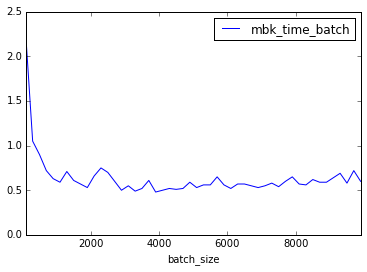

In [8]:
# plot optimal max batch size
mbk_batch_df = DataFrame(mbk_means_batch)
mbk_batch_df.columns = ['batch_size', 'mbk_time_batch']
mbk_batch_df.plot(x = 'batch_size',y = 'mbk_time_batch')

In [9]:
# minimum batch around 3000
min_batch = mbk_batch_df['batch_size'][mbk_batch_df['mbk_time_batch']==mbk_batch_df['mbk_time_batch'].min()].values
print(min_batch)

[3900]


In [10]:
# # Find optimal cluster size using 3000 as the batchsize

mbk_time(200, 3000)

5.6992621421813965

# **mbk_time(200, 3000) meaning 200 clusters at batchsize of 3000**

In [11]:
# create mini batch function that takes clustersize and batchsize as parameters
def optimal_mbk_time(cluster_size, batch_size):
    mbk = MiniBatchKMeans(init='k-means++', n_clusters=cluster_size, batch_size=batch_size,
                      n_init=10, max_no_improvement=10, verbose=0)
    t0 = time.time()
    mbk.fit(pair_coordinates)
    t_mini_batch = time.time() - t0
    mbk_means_labels = mbk.labels_
    mbk_means_cluster_centers = mbk.cluster_centers_
    mbk_means_labels_unique = np.unique(mbk_means_labels)
    return t_mini_batch, mbk_means_labels, mbk_means_cluster_centers, mbk_means_labels_unique


In [12]:
optimal_time, optimal_labels, optimal_centers, optimal_unique_labels = optimal_mbk_time(200,3000)
print("optimal time: {0}".format(optimal_time))
print("optimal labels: {0}".format(optimal_labels))
print("optimal centers: {0}".format(optimal_centers))
print("optimal unique labels: {0}".format(optimal_unique_labels))

optimal time: 5.449453830718994
optimal labels: [126 160  48 ...,  74 178  65]
optimal centers: [[  3341.12519325 -13727.16797202]
 [  3032.82307865 -13297.49592209]
 [  3398.0131527  -13758.82294575]
 [  3348.26769714 -13584.23350284]
 [  3562.78219311 -13751.11506607]
 [  2976.84185887 -13210.13948947]
 [  3389.54474755 -13793.56600083]
 [  3064.7765502  -13416.52376427]
 [  3458.21749685 -13722.1826827 ]
 [  2952.29591425 -13025.1633477 ]
 [  3059.687049   -13242.02706045]
 [  3443.98391592 -13685.42377559]
 [  3290.38358406 -13704.3291792 ]
 [  3166.51086664 -13599.96769685]
 [  3726.59446541 -13807.30621507]
 [  3369.25707835 -13751.98360597]
 [  3455.55603173 -13843.71458868]
 [  3092.16685593 -13369.20834145]
 [  3002.6630592  -13195.54929245]
 [  3403.11696738 -13803.72246963]
 [  3073.34145274 -13082.24342522]
 [  3403.82881734 -13714.070802  ]
 [  3359.27001657 -13653.00182002]
 [  3623.04313245 -13778.97838555]
 [  3523.61384716 -13711.35644365]
 [  3342.13520623 -13738.8930

In [13]:
type(optimal_labels)

numpy.ndarray

In [14]:
optimal_labels

array([126, 160,  48, ...,  74, 178,  65], dtype=int32)

In [15]:
len(optimal_labels)

1000000

In [16]:
full_list = list(zip(optimal_labels, pair_coordinates))

In [17]:
print(full_list[:2])
len(full_list)

[(126, [3358.915169103, -13736.276859249001]), (160, [3057.640302951, -13238.035471927002])]


1000000

** map out points: cluster by color **

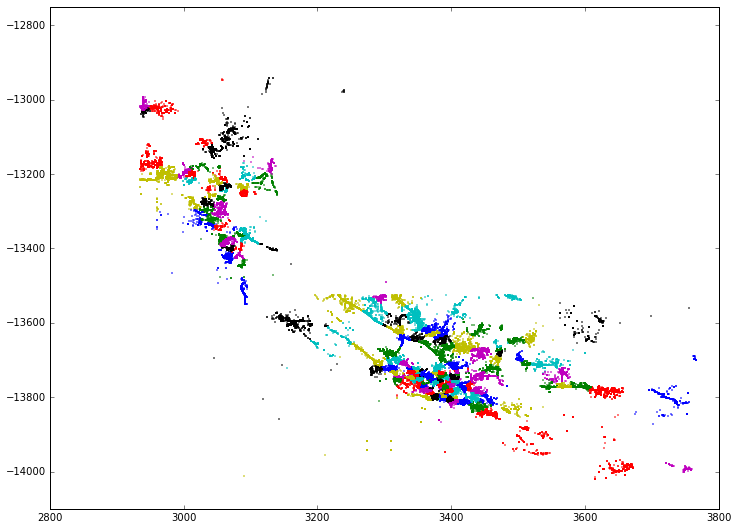

In [43]:
cluster_color = [item[0] for item in full_list ]
lat_mini = [item[1][0] for item in full_list]
long_mini = [item[1][1] for item in full_list]

# df = pandas.DataFrame(dict(lat_mini=lat_mini, long_mini=long_mini, cluster_color=cluster_color))

# #df = pandas.DataFrame(lat_mini=lat_mini, long_mini=long_mini, cluster_color=cluster_color)
# df.plot(kind='scatter', x='lat_mini', y='long_mini', color='DarkBlue')

df = pandas.DataFrame(dict(lat_mini=lat_mini, long_mini=long_mini, cluster_color=cluster_color))

groups = df.groupby('cluster_color')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.lat_mini, group.long_mini, marker='.', linestyle='', ms=2, label=name)
#ax.legend()
plt.xlim(2800, 3800)
plt.ylim(-14100, -12750)
plt.show()

## DBSCAN on the 200 clusters made by mini-batch

In [19]:
# append the coordinates to the specific cluster label (will be 200 total)
full_dict = dict() 
for label, coord in full_list:
    full_dict.setdefault(label, []).append(coord)

In [20]:
type(full_dict)

dict

In [21]:
# see how many data points are in each of the 200 clusters
for key, item in full_dict.items():
    print(key, len(item))

0 11759
1 3630
2 7663
3 2394
4 1017
5 1541
6 22312
7 3340
8 4565
9 871
10 3299
11 5142
12 1335
13 5311
14 751
15 14530
16 869
17 3483
18 4141
19 594
20 1951
21 6007
22 881
23 2614
24 4188
25 10040
26 909
27 12098
28 1143
29 7431
30 3293
31 2913
32 9959
33 5917
34 5079
35 1489
36 224
37 2708
38 447
39 3669
40 3209
41 727
42 12070
43 2895
44 2331
45 10034
46 844
47 1841
48 19847
49 14060
50 5515
51 1490
52 24066
53 2587
54 2640
55 1790
56 1925
57 22416
58 2754
59 10981
60 3545
61 733
62 2802
63 599
64 709
65 8396
66 5580
67 4756
68 3107
69 9983
70 1507
71 2080
72 2584
73 1456
74 3727
75 511
76 495
77 2073
78 5549
79 4092
80 2135
81 1386
82 1005
83 7995
84 2562
85 2388
86 4706
87 1187
88 2205
89 2341
90 1787
91 18510
92 614
93 270
94 8699
95 3022
96 432
97 14824
98 3750
99 8682
100 1254
101 927
102 2513
103 1645
104 1421
105 50634
106 1937
107 14926
108 1253
109 9919
110 1304
111 15
112 10416
113 1038
114 1435
115 1178
116 4296
117 1419
118 12250
119 8213
120 988
121 13273
122 1165
123 99

In [22]:
# prove that all points are accounted for
count = 0
for key, item in full_dict.items():
    count += len(item)
print(count)

1000000


In [23]:
def dbscan_time(cluster_n, eps_n, min_samples_n):
    t0 = time.time()
    mdb = DBSCAN(eps=eps_n, min_samples=eps_n).fit(cluster_n)
    n_labels = mdb.labels_ 
    n_clusters = len(set(n_labels)) - (1 if -1 in n_labels else 0)
    t_dbscan = time.time() - t0
    return t_dbscan, n_clusters

### First 1/8

In [24]:
len(full_dict)/8


24.875

In [25]:
def get_range(dictionary, begin, end):
  return {k: v for k, v in dictionary.items() if begin <= k <= end}

In [26]:
dict_first_eigth = get_range(full_dict, 0,25)
#len(dict_first_eigth)

In [27]:
dbscan_dict = {}
for key, coord in full_dict.items():
    temp_cluster = coord
    t_dbscan, n_clusters = dbscan_time(cluster_n=temp_cluster, eps_n=.1, min_samples_n=100)
    dbscan_dict[key] = n_clusters
    #print(len(temp_cluster)) # proves that temp_cluster is same as values in dict 

In [28]:
dbscan_dict

{0: 420,
 1: 183,
 2: 361,
 3: 317,
 4: 74,
 5: 216,
 6: 169,
 7: 212,
 8: 355,
 9: 154,
 10: 151,
 11: 367,
 12: 243,
 13: 534,
 14: 196,
 15: 568,
 16: 260,
 17: 352,
 18: 311,
 19: 119,
 20: 237,
 21: 334,
 22: 190,
 23: 246,
 24: 198,
 25: 437,
 26: 375,
 27: 236,
 28: 151,
 29: 294,
 30: 277,
 31: 167,
 32: 287,
 33: 478,
 34: 345,
 35: 130,
 36: 21,
 37: 199,
 38: 81,
 39: 319,
 40: 466,
 41: 113,
 42: 466,
 43: 228,
 44: 357,
 45: 541,
 46: 87,
 47: 303,
 48: 478,
 49: 357,
 50: 303,
 51: 169,
 52: 298,
 53: 160,
 54: 270,
 55: 250,
 56: 378,
 57: 474,
 58: 149,
 59: 554,
 60: 205,
 61: 77,
 62: 102,
 63: 224,
 64: 168,
 65: 366,
 66: 424,
 67: 261,
 68: 320,
 69: 524,
 70: 317,
 71: 301,
 72: 111,
 73: 152,
 74: 421,
 75: 117,
 76: 71,
 77: 244,
 78: 280,
 79: 111,
 80: 330,
 81: 278,
 82: 185,
 83: 360,
 84: 206,
 85: 101,
 86: 300,
 87: 112,
 88: 235,
 89: 213,
 90: 155,
 91: 236,
 92: 135,
 93: 70,
 94: 670,
 95: 155,
 96: 49,
 97: 347,
 98: 358,
 99: 244,
 100: 161,
 101: 6

In [29]:
# total number of clusters
total_clusters = 0
for key, value in dbscan_dict.items():
    total_clusters += value

print(total_clusters)


50948


I chose minibatch as to handle the 1M tweets. I first figured out what was the optimal batch size as we had done in part 1 and 2. After creating a for loop, ~3000 was about the optimal batch size. The second part of the process was to implement dbscan on each of the clusters. I first tried 100 clusters but the maximum amount of ponts within a given cluster was too many. My computer ran out of memory. I changed the minibatch to 200 clusters. The dbscan runs properly on this amount. 50879 total clusters were made after the two processes.